In [1]:
using Flux
using Plots

Is there an array subtype for *ordered* arrays? It may be worth trying to force $\vec{x}$ to be an ordered array. If not, we can define a list of indices to store upon calling the constructor for the binning layer. This would just tell us how to properly sort the elements of $\vec{x}$ (and therefore $\vec{f}$) so that we don't have to constantly do the sorting. 

# Binning layer for interpretable dimensionality-reduction 
**Guiding Question**: Everyone seems to agree that the $\alpha$, $\beta$, $\gamma$, $\delta$ "bands" are usefull for interpreting EEG data. Are these the ideal binnings of frequencies for analyzing EEGG data? 

**Goal**: we want to make a machine learning model that can learn the ideal *bins* to group the frequency components of a signal. 

**Abstract Goal**: we want to make a machine learning model that can be used for dimensionality reduction **and is interpretable**. 


* Tried implementing binning procedure using if-elseif-else blocks -- there is no way to differentiate an if statement, so this confused the ML autodiff behind the scenes. 
* Chose to use a convolution-like method instead by implmenting a smooth approximation to a step function via a combination of $arctan(x)$.

In [2]:
# define smooth function for "binning" process
function SmoothStep(x, bᵢ, bⱼ; α=5)
    # assume i < j
    return 0.5(tanh(α*(x-bᵢ))-tanh(α*(x-bⱼ))) # max val 1 min value 0 sharpness controlled by α
end

SmoothStep (generic function with 1 method)

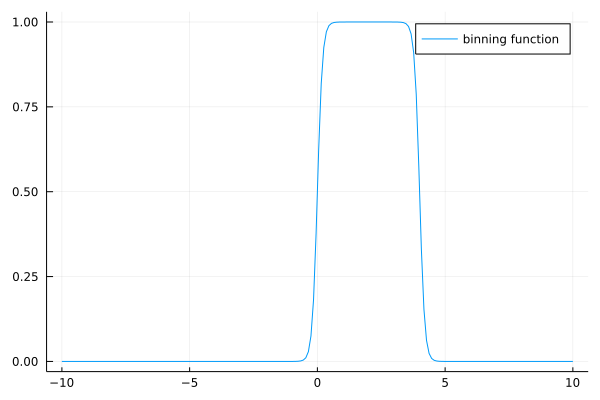

In [3]:
x = range(-10, stop=10, length=200) 
plot(x, SmoothStep.(x, 0, 4), label="binning function")

demonstrate the action of the binning function: It selects the relevant values of $f(x)$ that fall between the bin edges $b_i$ and $b_j$. 

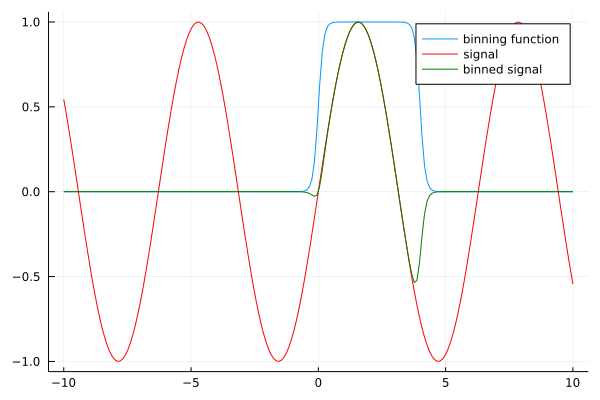

In [4]:
y = sin.(x) 

b_out = [sin(xᵢ)*SmoothStep(xᵢ, 0, 4) for xᵢ ∈ x]

plot!(x, y, color=:red, label="signal")
plot!(x, b_out, color=:green, label="binned signal")

To define a custom machine learning layer, we need to do three things:
1. Define the data structure of the layer (what do we store) 
2. Define how to construct the layer (e.g. how many bins, input data) 
3. Define how to call the layer as a function on data (i.e. how do we perform the binning operation)

In [5]:
# see https://fluxml.ai/Flux.jl/stable/models/advanced/

# define the structure of the layer
struct BinningLayer{S<:AbstractArray, T<:AbstractArray, N<:Number, M<:Number} 
    x::S # input values
    b::T # vector of bin edges
    b₁::N # start bin
    bₑ::M # end bin
end

# define layer constructor
function BinningLayer(x::AbstractArray, N::Integer)
    x_min = minimum(x) 
    x_max = maximum(x) 
    
    # may wan't to specify different bin initialization according to some distribution
    Δx = (x_max-x_min)/N 
    b1 = x_min
    be = x_max
    b = Array(x_min+Δx:Δx:x_max-Δx) 
    
    return BinningLayer(x, b, b1, be)
end

# set the trainable parameters to be bin positions within the boundaries
#Flux.trainable(L::BinningLayer) = (L.b[2:end-1],)
Flux.trainable(L::BinningLayer) = (L.b,)

# define how to call layer as a function
function (BL::BinningLayer)(f::AbstractArray)
    # collect bins and sort in ascending order
    b = sort(vcat(BL.b₁,BL.b, BL.bₑ))
    x = BL.x
    fout = [sum([f[j]*SmoothStep(x[j], b[i-1], b[i]) for j ∈ 1:length(x)]) for i ∈ 2:length(b)]
    return fout
end


# Test Case: optimal binning for preserving the integral
As a test, let's take 1000 function values representing some signal and bin them to 20 while maintaining the integral of the signal. 

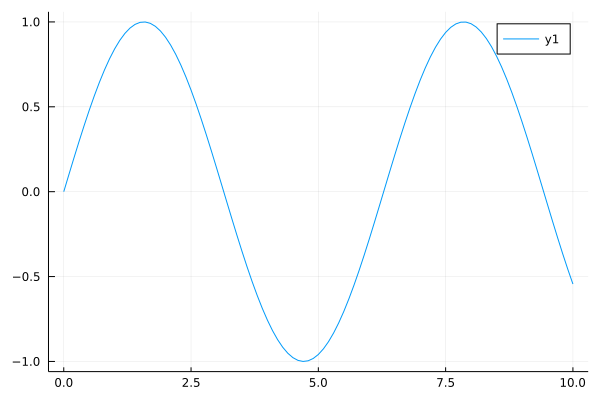

In [6]:
x = Array(0:.1:10)
f = sin.(x)
plot(x, f)

In [7]:
function getBinCenters(BL::BinningLayer)
    b = sort(vcat(BL.b₁,BL.b, BL.bₑ))
    [(b[i]+b[i-1])/2 for i ∈ 2:length(b)]
end

getBinCenters (generic function with 1 method)

In [8]:
testBinner = BinningLayer(x, 20)
binit = testBinner.b

19-element Vector{Float64}:
 0.5
 1.0
 1.5
 2.0
 2.5
 3.0
 3.5
 4.0
 4.5
 5.0
 5.5
 6.0
 6.5
 7.0
 7.5
 8.0
 8.5
 9.0
 9.5

In [9]:
@show size(testBinner.b)
println(params(testBinner))

size(testBinner.b) = (19,)
Params([[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5]])


In [10]:
fnew = testBinner(f)
xnew = getBinCenters(testBinner)

20-element Vector{Float64}:
 0.25
 0.75
 1.25
 1.75
 2.25
 2.75
 3.25
 3.75
 4.25
 4.75
 5.25
 5.75
 6.25
 6.75
 7.25
 7.75
 8.25
 8.75
 9.25
 9.75

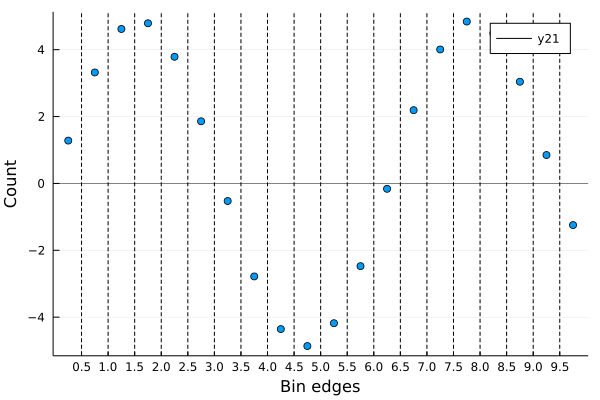

In [11]:
p1 = Plots.scatter(xnew, fnew, label="")
xticks!(p1, testBinner.b)
for bin in testBinner.b
    vline!(p1, [bin], linestyle=:dash, color=colorant"black", label="")
end
xlabel!("Bin edges")
ylabel!("Count")
hline!([0], color=colorant"black", linewidth=.5)
display(p1)

(20,)(21,)
2
3

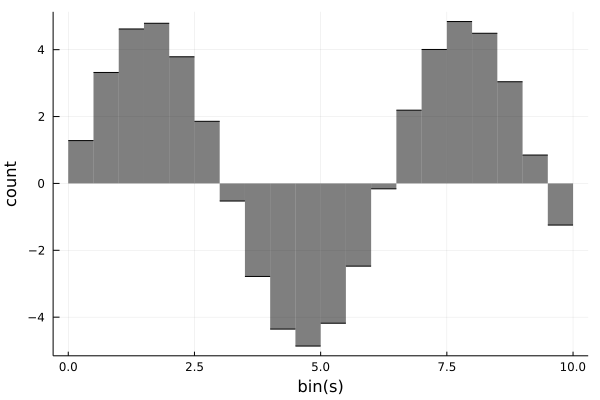


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [12]:
p = plot()
b = sort(vcat(testBinner.b₁,testBinner.b, testBinner.bₑ))
println(size(fnew), size(b))

for i ∈ 2:length(b)
    println(i)
    plot!(p, b[i-1:i], [fnew[i-1], fnew[i-1]], color=:black, fill=(0, 0.5, :black), label="")
end
xlabel!("bin(s)")
ylabel!("count")
display(p)

Now let's define a loss function to try to find a set of bins to match the area

In [13]:
# the problem is in the loss function

function loss()
    bins = sort(vcat(testBinner.b₁,testBinner.b, testBinner.bₑ))
    fnew = testBinner(f)
    Δx = [bins[i]-bins[i-1] for i ∈ 2:length(bins)]
    Î = sum([fnew[i]*Δx[i] for i ∈ 1:length(fnew)])
    I = sum(0.1.*f)
    return (Î-I)^2 # square to make sure loss > 0 
end

function binSpreadLoss()
    bins = sort(vcat(testBinner.b₁,testBinner.b, testBinner.bₑ))
    bmin = bins[1]
    bmax = bins[end]
    E = abs(bmax-bmin)-(testBinner.bₑ-testBinner.b₁)
end

λ=1
function composedLoss() 
    return loss() + λ*binSpreadLoss()
end


println(loss()) 
println(binSpreadLoss())
println(composedLoss())

55.20869292995489
0.0
55.20869292995489


In [14]:
opt = Descent(0.0005)
data = Iterators.repeated((), 200)
ps = params(testBinner) 
println(ps)

Params([[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5]])


In [15]:
Flux.train!(composedLoss, ps, data, opt, cb=()->println(composedLoss()))

49.462049230834054
44.40835014096609
39.922637939312104
35.91165505998859
32.30425183209109
29.044957341329525
26.089591458997848
23.40223680230073
20.953130877601172
18.717185956673333
16.67294225730147
14.801828774074323
13.087654355590107
11.516282856921517
10.075461798917493
8.754775005146797
7.545678192059152
6.441556637213927
5.437723311251894
4.531265487238515
3.7206613465157656
3.005136064833193
2.38380817704995
1.8547707881931499
1.414318754970129
1.056530681986264
0.7733275333581908
0.5549864911670366
0.39095259562065454
0.27072226745714845
0.184593295531635
0.12415962901584571
0.08252755153906442
0.05430235924380867
0.035426483938497705
0.022947898953120518
0.014777514488763722
0.009470317434987472
0.006045349212039691
0.0038467691173910148
0.0024414965158583678
0.0015463939620545416
0.0009778361650965004
0.0006175012064123131
0.0003895391854406198
0.000245526928871845
0.00015465224287594087
9.736030610343839e-5
6.126659182396637e-5
3.854068331515556e-5
2.4238128800708266e-5

In [16]:
composedLoss()

1.2939290997887646e-27

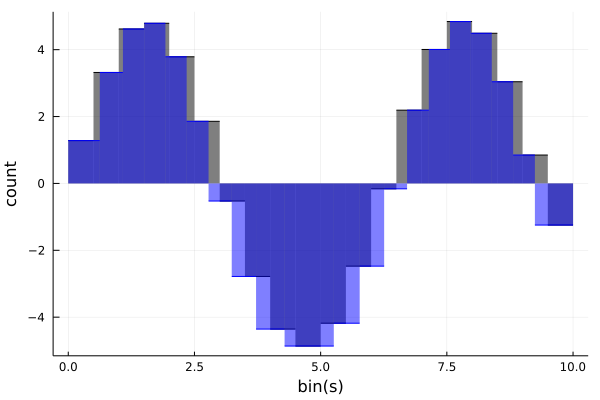

In [17]:
#p1 = plot()
b = sort(vcat(testBinner.b₁,testBinner.b, testBinner.bₑ))

for i ∈ 2:length(b)
    plot!(p, b[i-1:i], [fnew[i-1], fnew[i-1]], color=:blue, fill=(0, 0.5, :blue), label="")
end
xlabel!("bin(s)")
ylabel!("count")
display(p)

# Generalizing to 2 dimensions (i.e. for image analysis)

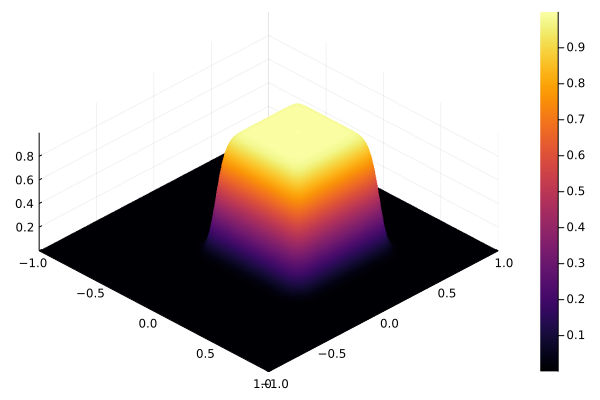

In [18]:
x = -1:0.01:1
y = -1:0.01:1 

b₁ = -0.25
b₂ = 0.5

#X= [xi for xi∈x, yj∈y]
#Y= [yj for xi∈x, yj∈y]

F2(x, y) = SmoothStep(x, b₁, b₂; α=20)*SmoothStep(y, b₁, b₂; α=20)


plot(x, y,F2,st=:surf, camera=(45,70))

# Generalizing to N dimensions